In this directory I use astronomical images to train neural network. In this notebook I save larger star images, useful galaxy type identification and also find the reason why some object are wrongly classified. 

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


Now loading the data on the classification and other properties of the objects to be classified. 

In [2]:
df=pd.read_csv('Stripe82_1b.csv',sep=',')
print(df.columns)

Index(['objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'probPSF_u', 'probPSF_g', 'probPSF_r', 'probPSF_i',
       'probPSF_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'run', 'rerun',
       'camcol', 'field', 'type', 'specobjid', 'class', 'subclass', 'redshift',
       'zErr', 'zWarning', 'zErr_noqso', 'zWarning_noqso', 'z_noqso',
       'snMedian_r', 'snMedian_i', 'z_person', 'class_person', 'plate', 'mjd',
       'fiberid'],
      dtype='object')


Now looking on the classes, the targets and their counts. 

In [3]:
print(df['class'].value_counts())
dfpr=df[df['probPSF_r']==1]
#some galaxies look star like 
print(dfpr['class'].value_counts())

GALAXY    3205
STAR      1735
QSO        355
Name: class, dtype: int64
STAR      1650
QSO        279
GALAXY      51
Name: class, dtype: int64


Making a color (a difference of two magntudes) magnitude diagram. Thiskind of data (there are in total 5 magnitudes) could also be used for classification. 
For now it is ignore since the aim is to use images first. 

(26.0, 12.0)

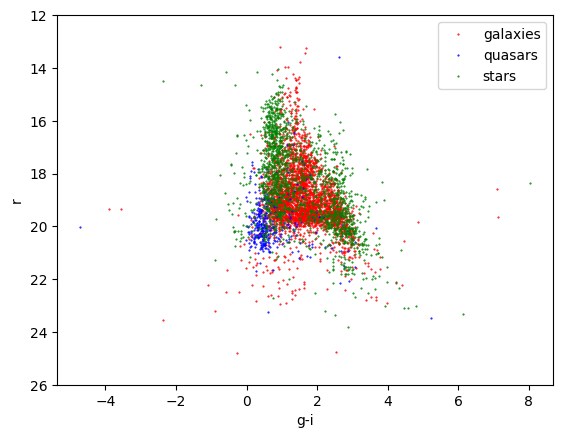

In [4]:
plt.plot(df['modelMag_g'][df['class']=='GALAXY']-df['modelMag_i'][df['class']=='GALAXY'],df['modelMag_r'][df['class']=='GALAXY'],'o',ms=0.5,color='red',label='galaxies') 
plt.plot(df['modelMag_g'][df['class']=='QSO']-df['modelMag_i'][df['class']=='QSO'],df['modelMag_r'][df['class']=='QSO'],'o',ms=0.5,color='blue',label='quasars')
plt.plot(df['modelMag_g'][df['class']=='STAR']-df['modelMag_i'][df['class']=='STAR'],df['modelMag_r'][df['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.legend(loc="best")
plt.xlabel("g-i")
plt.ylabel("r")
plt.ylim(26,12)
#plt.yscale("log")


In [5]:
#slect some stars exclude brightest because possible daturated (shpuld check qso below are they more likely borderline classifuied)

(18.0, 14.8)

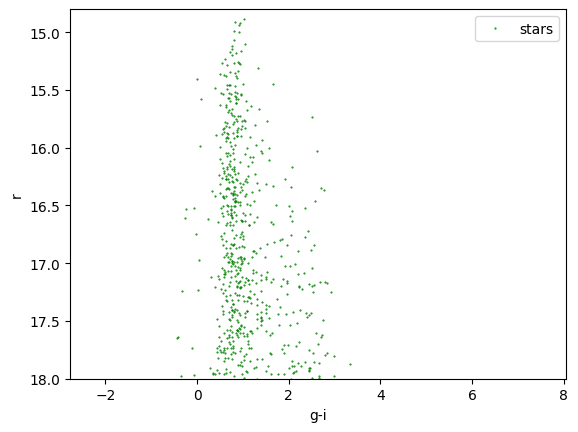

In [6]:
plt.plot(df['psfMag_g'][df['class']=='STAR']-df['psfMag_i'][df['class']=='STAR'],df['psfMag_r'][df['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.legend(loc="best")
plt.xlabel("g-i")
plt.ylabel("r")
plt.ylim(18,14.8)

In [7]:
#get a clean star sample which is added to the clean galaxy types (should also make type here cleaner can combine spec and phot)
dfst=df[(df['probPSF_r']==1 ) & (df['probPSF_i']==1 ) & (df['probPSF_g']==1 )  &(df['class']=='STAR') & (df['psfMag_r']>14.8) & (df['psfMag_r']<18.0)]
print(dfst.shape)
#get random subset of about 120 
dfst_selected,dfst_other= train_test_split(dfst,train_size=0.20, shuffle=True, random_state=1)
print(dfst_selected.shape)
#but at the end i use all to have more stars can be ignored still later 

(624, 42)
(124, 42)


Now I load an image and to do a first test display of the numeric data.

In [8]:
path='/home/tobias/ml-testing/astr-images/'
hbin=fits.open(path+'f2001_rdeep.fits.gz')
im1=hbin[0].data
#hbin.close()
print(im1)

[[-0.1769429   0.8691173   0.8408659  ... -1.000337   -0.7853276
  -0.45219374]
 [ 0.75963277 -0.4932522   1.3954576  ... -0.41785482 -1.3604484
  -0.5760638 ]
 [ 0.74020797  0.50546163  0.67057353 ...  0.37528276 -0.6279215
  -0.12317654]
 ...
 [ 0.8284947   0.14578946 -0.6937766  ...  1.4887718   2.2809432
   2.2037222 ]
 [ 0.9416072   0.7137203   0.43595394 ...  1.1946634   2.0303423
   2.3305871 ]
 [ 0.57620764 -0.2957804   0.5933519  ...  0.98817205  1.3469133
   2.5567775 ]]


I now built a function which gets the area mcovers by an image. That is used later to find the right image for the targets.

In [9]:
def image_area(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    image=dat[0].data
    res=np.array([[ra_ref+(1-ra_center)*ra_scale,ra_ref+(image.shape[0]-ra_center)*ra_scale],[dec_ref+(1-dec_center)*dec_scale,dec_ref+(image.shape[1]-dec_center)*dec_scale]])
    return res

Similiarly the function image_par gets the coordinate parameter of an image for this data set.

In [10]:
#assumes that the image pixel coordiantes are perfectly aligned with the skyb coordiates ra and dec
#that is true for this data set but in general another two parameters are needed to specify the miss alignment
def image_par(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    par=np.array([ra_ref,ra_center,ra_scale,dec_ref,dec_center,dec_scale])
    return par

Below I build a function which gets the image position of an object whose sky position is known. 
The information on the image can be either obtained from an image or from the opreviously collected image coordinate parameters.

In [12]:
#ra dec position coordinate of object, dat is image inpt, not zero if image==True,
# par is parameter inpu not yero if image==False
def image_xy(ra,dec,dat=0,par=0,image=True):
    #image is used input and the parameters are used
    if image==True:
        ra_ref=dat[0].header['CRVAL1']
        ra_center=dat[0].header['CRPIX1']
        ra_scale=dat[0].header['CD1_1']
        dec_ref=dat[0].header['CRVAL2']
        dec_center=dat[0].header['CRPIX2']
        dec_scale=dat[0].header['CD2_2'] 
    #paramter input    
    else:   
        ra_ref=par[0]
        ra_center=par[1]
        ra_scale=par[2]
        dec_ref=par[3]
        dec_center=par[4]
        dec_scale=par[5]
    #get the positions (pixels on image) 
    # the cosine part is only important if the image not close to the euqator 
    x=ra_center+(ra-ra_ref)/ra_scale*np.cos(dec/180*np.pi)
    y=dec_center+(dec-dec_ref)/dec_scale
    pixels=np.array([x,y])
    return pixels

Now getting all images in a list. 

In [15]:
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

['f2001_rdeep.fits.gz', 'f2002_rdeep.fits.gz', 'f2003_rdeep.fits.gz', 'f2004_rdeep.fits.gz', 'f2005_rdeep.fits.gz', 'f2011_rdeep.fits.gz', 'f2012_rdeep.fits.gz', 'f2013_rdeep.fits.gz', 'f2014_rdeep.fits.gz', 'f2015_rdeep.fits.gz', 'f2021_rdeep.fits.gz', 'f2022_rdeep.fits.gz', 'f2023_rdeep.fits.gz', 'f2024_rdeep.fits.gz', 'f2025_rdeep.fits.gz', 'f2031_rdeep.fits.gz', 'f2032_rdeep.fits.gz', 'f2033_rdeep.fits.gz', 'f2034_rdeep.fits.gz', 'f2035_rdeep.fits.gz', 'f2041_rdeep.fits.gz', 'f2042_rdeep.fits.gz', 'f2043_rdeep.fits.gz', 'f2044_rdeep.fits.gz', 'f2045_rdeep.fits.gz', 'f2051_rdeep.fits.gz', 'f2052_rdeep.fits.gz', 'f2053_rdeep.fits.gz', 'f2054_rdeep.fits.gz', 'f2055_rdeep.fits.gz', 'f2061_rdeep.fits.gz', 'f2062_rdeep.fits.gz', 'f2063_rdeep.fits.gz', 'f2064_rdeep.fits.gz', 'f2065_rdeep.fits.gz']


Now I get the centers and image parameters for all images.

In [16]:
centers=np.zeros((2,len(list_input_files)))
wcs_par=np.zeros((6,len(list_input_files)))
for i in range(len(list_input_files)):
    print(i)
    #get images
    hbin=fits.open(path+list_input_files[i],memmap=True)
    #get parameters wanted 
    res=image_area(hbin)
    par=image_par(hbin)
    hbin.close()
    centers[0,i]=(res[0,0]+res[0,1])/2  #center is avarage of extension in both dimensions
    centers[1,i]=(res[1,0]+res[1,1])/2
    #parameters to find objects on images
    wcs_par[:,i]=par
print(centers)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
[[ 4.97500000e+01  4.97500000e+01  4.97500000e+01  4.97500000e+01
   4.97500000e+01  5.02500000e+01  5.02500000e+01  5.02500000e+01
   5.02500000e+01  5.02500000e+01  5.07500000e+01  5.07500000e+01
   5.07500000e+01  5.07500000e+01  5.07500000e+01  5.12500000e+01
   5.12500000e+01  5.12500000e+01  5.12500000e+01  5.12500000e+01
   5.17500000e+01  5.17500000e+01  5.17500000e+01  5.17500000e+01
   5.17500000e+01  5.22500000e+01  5.22500000e+01  5.22500000e+01
   5.22500000e+01  5.22500000e+01  5.27500000e+01  5.27500000e+01
   5.27500000e+01  5.27500000e+01  5.27500000e+01]
 [-1.00000000e+00 -5.00000000e-01 -1.08246745e-15  5.00000000e-01
   1.00000000e+00 -1.00000000e+00 -5.00000000e-01 -1.08246745e-15
   5.00000000e-01  1.00000000e+00 -1.00000000e+00 -5.00000000e-01
  -1.08246745e-15  5.00000000e-01  1.00000000e+00 -1.00000000e+00
  -5.00000000e-01 -1.08246745e-15  5.00000000e-01  1.00000000e

Now I am getting closest image and the pixels positions on them for all objects of the data frame. Further I create a binary classifier based on whether a galaxy or not to start with a  simple binary classification case. I assume thereby that QSOs are like stars which should be at least approximate the case. 

In [17]:
df['galaxy'] = np.where(df['class']== 'GALAXY', True, False)
#Also I add dummy columns which are later filter with the image and the pixels positions on it for all onbjects
df['image']=-1
df['pixel_x']=-1.0
df['pixel_y']=-1.0
print(df.galaxy.value_counts())

True     3205
False    2090
Name: galaxy, dtype: int64


In [25]:
dfst['image']=-1
dfst['pixel_x']=-1.0
dfst['pixel_y']=-1.0

Below I go over all objects, find the closest image and get then the pixel position of the object.. 

In [19]:
def get_object_pos(df2,centers,wcs_par):
    for i in range(df2.shape[0]):
        #distances to all images ceneters
        r=np.sqrt((df2['ra'].iloc[i]-centers[0])**2+(df2['dec'].iloc[i]-centers[1])**2)
        #id of the image
        df2['image'].iloc[i]=np.argmin(r)
        #get pixel coordinates of image 
        coor=image_xy(df2['ra'].iloc[i],df2['dec'].iloc[i],par=wcs_par[:,df2['image'].iloc[i]],image=False)
        df2['pixel_x'].iloc[i]=coor[0]
        df2['pixel_y'].iloc[i]=coor[1]
    return df2     

In [26]:
print(df.columns)
print(dfst.columns)
df=get_object_pos(df,centers,wcs_par)
dfst=get_object_pos(dfst,centers,wcs_par)

Index(['index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r',
       'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g', 'probPSF_r',
       'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g', 'modelMag_r',
       'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r', 'petroRad_i',
       'run', 'rerun', 'camcol', 'field', 'type', 'specobjid', 'class',
       'subclass', 'redshift', 'zErr', 'zWarning', 'zErr_noqso',
       'zWarning_noqso', 'z_noqso', 'snMedian_r', 'snMedian_i', 'z_person',
       'class_person', 'plate', 'mjd', 'fiberid', 'galaxy', 'image', 'pixel_x',
       'pixel_y', 'off_image'],
      dtype='object')
Index(['objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'probPSF_u', 'probPSF_g', 'probPSF_r', 'probPSF_i',
       'probPSF_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'run', 'rerun',
       'camcol', 'field', 'type', 'specobjid', 'class'

/tmp/ipykernel_8308/2058630707.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['image'].iloc[i]=np.argmin(r)
/tmp/ipykernel_8308/2058630707.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pixel_x'].iloc[i]=coor[0]
/tmp/ipykernel_8308/2058630707.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pixel_y'].iloc[i]=coor[1]


I now sort the row of the data frame by image, that minizie how often the images need to be loaded. 

In [27]:
df=df.sort_values(by='image')
#reset index since the previous row is not wanted 
df=df.reset_index()

dfst=dfst.sort_values(by='image')
#reset index since the previous row is not wanted 
dfst=dfst.reset_index()

Now the arrays with the images are collected. For now I collected 11 times 11 pixels. The n umber is odd because it should usually centered on the brightest image. 

In [28]:
def get_cutouts(df,delta):
    #collected array
    c=0
    cut_outs=np.zeros((2*delta+1,2*delta+1,df.shape[0]))
    #parameter to indicate whether an image exist. 
    df['off_image']=False
    for i in range(df.shape[0]):
        #image loaded if first image
        if i==0:
            #load file
            hbin=fits.open(path+list_input_files[df.image.iloc[i]])
            #get image, need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
            image=hbin[0].data.T
        else:
            #or if new image
            if df.image.iloc[i]!=df.image.iloc[i-1]:
                hbin=fits.open(path+list_input_files[df.image.iloc[i]])
                #need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
                image=hbin[0].data.T  
        #gfigure out if within image borders  then cut out image is collected       
        if round(df.pixel_x.iloc[i])>delta and round(df.pixel_x.iloc[i])<image.shape[0]-delta and  round(df.pixel_y.iloc[i])>delta and round(df.pixel_y.iloc[i])<image.shape[1]-delta:
            cut_outs[:,:,i]=image[round(df.pixel_x.iloc[i])-delta:round(df.pixel_x.iloc[i])+delta+1,round(df.pixel_y.iloc[i])-delta:round(df.pixel_y.iloc[i])+delta+1]
        else:
            #if not marker column set to true
            print(f"row {i} is off the image")
            df['off_image'].iloc[i]=True
            c+=1
    print(f"{c} objects are off the image")        
    return df, cut_outs 

In [29]:
dfst,cut_out_stars=get_cutouts(dfst,21)
df,cut_outs=get_cutouts(df,5)

row 29 is off the image


/tmp/ipykernel_8308/3785122936.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['off_image'].iloc[i]=True


row 105 is off the image
row 132 is off the image
row 133 is off the image
row 149 is off the image
row 181 is off the image
row 259 is off the image
row 293 is off the image
row 385 is off the image
row 544 is off the image
row 607 is off the image
11 objects are off the image
row 191 is off the image
row 222 is off the image
row 223 is off the image
row 890 is off the image
row 937 is off the image
row 940 is off the image
row 972 is off the image
row 979 is off the image
row 1272 is off the image
row 2065 is off the image
row 2114 is off the image
row 2148 is off the image
row 2475 is off the image
row 2845 is off the image
row 2850 is off the image
row 2857 is off the image
row 2910 is off the image
row 2958 is off the image
row 2996 is off the image
row 3081 is off the image
row 3082 is off the image
row 3659 is off the image
row 3842 is off the image
row 3852 is off the image
row 3881 is off the image
row 3962 is off the image
row 4079 is off the image
row 4145 is off the image
r

Now I check how rows are off the image.

In [30]:
print(df.off_image.value_counts())
print(dfst.off_image.value_counts())

False    5259
True       36
Name: off_image, dtype: int64
False    613
True      11
Name: off_image, dtype: int64


Not many, thus they can be ignore. Now  display one object of each kind. 

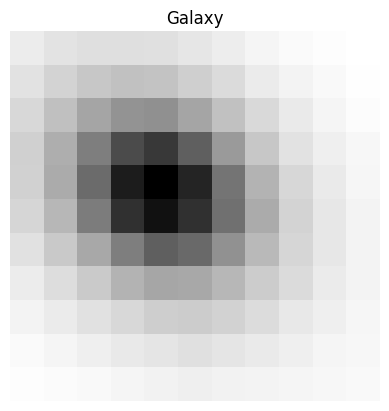

In [25]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs[:,:,0].T,cmap=cm.gray, interpolation='nearest')

In [26]:
#finding star and galaxies for display
fs=df['class'][df['class']=='STAR']
print(fs)
fq=df['class'][df['class']=='QSO']
print(fq)

1       STAR
2       STAR
3       STAR
5       STAR
6       STAR
        ... 
5286    STAR
5287    STAR
5288    STAR
5289    STAR
5294    STAR
Name: class, Length: 1735, dtype: object
4       QSO
27      QSO
28      QSO
51      QSO
67      QSO
       ... 
5229    QSO
5240    QSO
5249    QSO
5268    QSO
5292    QSO
Name: class, Length: 355, dtype: object


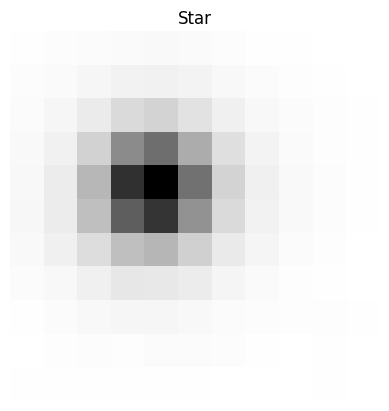

In [27]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs[:,:,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

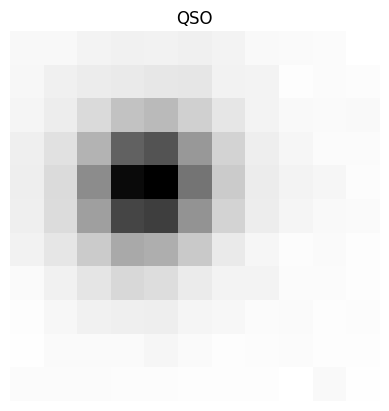

In [28]:
plt.axis('off')
plt.title("QSO")
plt.imshow(1-cut_outs[:,:,fq.index[0]].T,cmap=cm.gray, interpolation='nearest')

As it should be the galaxy is less concentrated than the star and the QSO. It is also visisble that the object are not fully isolated as often the case for images. 


Now looking on the large image of stars. 

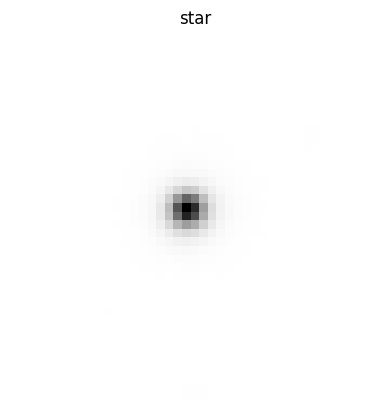

In [31]:
plt.axis('off')
plt.title("star")
plt.imshow(-cut_out_stars[:,:,0].T,cmap=cm.gray, interpolation='nearest')

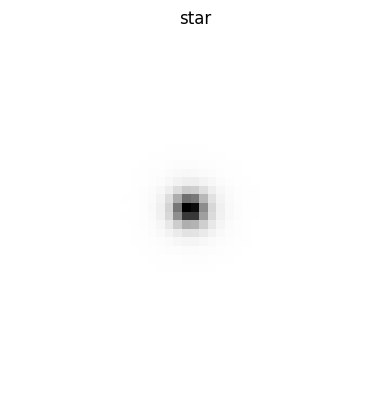

In [32]:
plt.axis('off')
plt.title("star")
plt.imshow(-cut_out_stars[:,:,90].T,cmap=cm.gray, interpolation='nearest')

Look good the stars are now saved.

In [34]:
#new data frame omitting the object where no image could be found 
df2st=dfst[dfst.off_image==False]
delta=21
#new image array, to which also a 4 dimension of zero size is added 
cut_st_final=np.zeros((2*delta+1,2*delta+1,1,df2st.shape[0]))
counter=0
for i in range(dfst_selected.shape[0]):
    if dfst.off_image.iloc[i]==False:
        #adding the cut outs not of image
        cut_st_final[:,:,0,counter]=cut_out_stars[:,:,i]
        counter+=1
print(counter,cut_st_final.shape)
np.save("stripe82_1_stars_im.npy",cut_out_stars)    
df2st.to_csv('stripe82_1_stars_table.csv') 

122 (43, 43, 1, 613)


I now drop the objects for which no image could have been found. I also add a forth dimension to the iamge array as needed by pytorch. I could add other colors, but for now I just use one color. The color I use combines the three color with the highest signal to noise to a single. That is useful in astronomy because astronomical images are noisy. 

Because of the noise to I not rescale the cut out images, since rescaling makes that noise is level is very different between different images, while it should be rather similar in this data set.    

In [35]:
#new data frame omitting the object where no image could be found 
df2=df[df.off_image==False]
delta=5
#new image array, to which also a 4 dimension of zero size is added 
cut_outs2=np.zeros((2*delta+1,2*delta+1,1,df2.shape[0]))
counter=0
for i in range(df.shape[0]):
    if df.off_image.iloc[i]==False:
        #adding the cut outs not of image
        cut_outs2[:,:,0,counter]=cut_outs[:,:,i]
        counter+=1
#Now I add the iamge value to the data frame, that can be used for all connected percitron networks 
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1

/tmp/ipykernel_8308/2406619642.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_8308/2406619642.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_8308/2406619642.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Now the data is mostly prepared besides some libraries specifices. 



First I do basic setup tasks relevant for for all torch networks. For now that these are two, firstly a fully connected multilayer network as perceptron. Secondly, a network which uses twodiemnsionalk convolutional layer whoch should be optimized for images. 

First adding the cpu. 

In [36]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [37]:
#need to be transposed to get into torch format of batch, channels, x, y
#splitting, feature_mlp, targets, feature_images, df properties
feature_train,feature_test,target_train, target_test,image_train,image_test,df2_train,df2_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.70, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(3681, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [38]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create a class which creates the classification data sets as needed for torch. 

In [39]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Now I create the data sets as needed for both neural network types. 

In [40]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
#print type as test 
print(type(torch.from_numpy(image_test).float()))
print(type(test_im_dataset))


<class 'torch.Tensor'>
<class '__main__.ClassificationDataset'>


Now create the class of the perceptron layer. 

In [41]:
#now 3 layers 
#two options only 
class BinaryClassification3(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification3, self).__init__()
        self.fc1 = nn.Linear(num_features, 60)
        self.fc2 = nn.Linear(60, 20)  
        self.fc3 = nn.Linear(20, 8)        
        self.fc4 = nn.Linear(8, 1)   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return (x)

Now I define the parameters needed. 

In [42]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 121
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the model plus the final parameters. 

In [35]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats = {
    'train': [], 'test': []
}


BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


Now I define a function which predicts the values (probablities) for all samples. 

In [55]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

Now I am building a first convolutional network. First loading the data again.  

In [56]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

Below is the neural network.

In [57]:
class CNNBinary3(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary3, self).__init__()
        # L1 ImgIn shape=(?, 11, 11, 1)
        # Conv -> (?, 9, 9, 12)
        # Pool -> (?, 4, 4, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 4, 4, 32)
        # Conv      ->(?, 2, 2, 32)
        # Pool      ->(?, 1, 1, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 FC 1x1x32 inputs -> 16 outputs
        self.fc1 = torch.nn.Linear(1 * 1 * 32, 64, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 64 inputs -> 1 output
        self.fc2 = torch.nn.Linear(64, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out

Define the model. 

In [58]:
keep_prob=1
model2 =CNNBinary3()
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_8308/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


Below I define a function to automize the calling of the fit. 

In [59]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect sats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

Define function to get confusion matrix. 

In [60]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

Now I define a function to execute several l2 regularization of the same model after each other. 

In [61]:
#loop on regularization 
#model used, train set, test set, train set for predict, train_target, test_target
#epochs, batch?size, alpha of fit, list of regularization, optional number of features needed for perceptron 
def run_loop_torch(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

Now also adding regularization to xgboost. Here the function.

In [62]:
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

Here I define a funcution which several l2 regularizations for  logistic regression. 

In [63]:
def loop_logistic(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=LogisticRegression(max_iter=3000,penalty='l2',C=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

Here I just run the best regularizations of all four options, average the three best and look on the miss classsifed cases to see what is the reason. I decide to use log loss as to find the best one. 


First I run xgboost.

In [52]:
xc2=XGBClassifier(max_depth=6,reg_lambda=30.0).fit(feature_train,target_train)
x2_train_pred_prob=xc2.predict_proba(feature_train)
x2_test_pred_prob=xc2.predict_proba(feature_test)

Then Logistic regression.

In [55]:
lc2=LogisticRegression(penalty='l2',C=0.0003,max_iter=3000).fit(feature_train,target_train)
l2_train_pred_prob=lc2.predict_proba(feature_train)
l2_test_pred_prob=lc2.predict_proba(feature_test)

Then multilayer percitron network. 

In [64]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,200,64,0.001,loss_stats_test3,l2reg=0.01)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59685 | Test Loss: 0.43936
Epoch 002: | Train Loss: 0.44701 | Test Loss: 0.41797
Epoch 003: | Train Loss: 0.39236 | Test Loss: 0.33893
Epoch 004: | Train Loss: 0.33348 | Test Loss: 0.35436
Epoch 005: | Train Loss: 0.28348 | Test Loss: 0.36454
Epoch 006: | Train Loss: 0.24503 | Test Loss: 0.87303
Epoch 007: | Train Loss: 0.34303 | Test Loss: 0.35173
Epoch 008: | Train Loss: 0.38995 | Test Loss: 0.35630
Epoch 009: | Train Loss: 0.30521 | Test Loss: 0.34676
Epoch 010: | Train Loss: 0.27310 | Test Loss: 0.34429
Epoch 011: | Train Loss: 0.27512 | Test Loss: 0.35083
Epoch 012: | Train Loss: 0.26410 | Test Loss: 0.34346
Epoch 013: | Train Loss: 0.26446 | Test Loss: 0.29320
Epoch 014: | Train Loss: 0.24031 | Test Loss: 0.34714
Epoch 015: | Train Loss: 0.24500 | Test Loss: 0.36107
Epoch 016: | Train Loss: 0.26545 | Test Loss: 0.44150
Epoch 017: | Train Loss: 0.23827 | Test Loss: 0.42449
Epoch 018: | Train Loss: 0.24898 | Test Loss: 0.36299
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.21119 | Test Loss: 0.35530
Epoch 154: | Train Loss: 0.21841 | Test Loss: 0.17876
Epoch 155: | Train Loss: 0.20986 | Test Loss: 0.24511
Epoch 156: | Train Loss: 0.20421 | Test Loss: 0.23780
Epoch 157: | Train Loss: 0.20406 | Test Loss: 0.41984
Epoch 158: | Train Loss: 0.20626 | Test Loss: 0.30659
Epoch 159: | Train Loss: 0.20365 | Test Loss: 0.35777
Epoch 160: | Train Loss: 0.20594 | Test Loss: 0.35808
Epoch 161: | Train Loss: 0.20543 | Test Loss: 0.26141
Epoch 162: | Train Loss: 0.22864 | Test Loss: 0.18362
Epoch 163: | Train Loss: 0.20816 | Test Loss: 0.35752
Epoch 164: | Train Loss: 0.20844 | Test Loss: 0.41853
Epoch 165: | Train Loss: 0.20503 | Test Loss: 0.30146
Epoch 166: | Train Loss: 0.20939 | Test Loss: 0.19409
Epoch 167: | Train Loss: 0.20978 | Test Loss: 0.19192
Epoch 168: | Train Loss: 0.20461 | Test Loss: 0.29714
Epoch 169: | Train Loss: 0.22382 | Test Loss: 0.18956
Epoch 170: | Train Loss: 0.20578 | Test Loss: 0.24204
Epoch 171: | Train Loss: 0.2

Then convolutional neural network. 

In [65]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3()            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test_c,l2reg=0.003)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/tmp/ipykernel_8308/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 31.66360 | Test Loss: 3.53519
Epoch 002: | Train Loss: 3.07987 | Test Loss: 1.68686
Epoch 003: | Train Loss: 1.53068 | Test Loss: 0.77648
Epoch 004: | Train Loss: 1.06805 | Test Loss: 0.97052
Epoch 005: | Train Loss: 1.04758 | Test Loss: 0.61570
Epoch 006: | Train Loss: 0.84975 | Test Loss: 0.54982
Epoch 007: | Train Loss: 0.74151 | Test Loss: 0.53181
Epoch 008: | Train Loss: 0.61935 | Test Loss: 0.47701
Epoch 009: | Train Loss: 0.46203 | Test Loss: 0.44798
Epoch 010: | Train Loss: 0.43411 | Test Loss: 0.43410
Epoch 011: | Train Loss: 0.38019 | Test Loss: 0.44364
Epoch 012: | Train Loss: 0.52423 | Test Loss: 0.44908
Epoch 013: | Train Loss: 0.33070 | Test Loss: 0.37570
Epoch 014: | Train Loss: 0.29061 | Test Loss: 0.45122
Epoch 015: | Train Loss: 0.31338 | Test Loss: 0.38136
Epoch 016: | Train Loss: 0.28432 | Test Loss: 0.37219
Epoch 017: | Train Loss: 0.28277 | Test Loss: 0.37234
Epoch 018: | Train Loss: 0.24910 | Test Loss: 0.37603
Epoch 019: | Train Loss: 0.

Epoch 153: | Train Loss: 0.16083 | Test Loss: 0.30685
Epoch 154: | Train Loss: 0.16525 | Test Loss: 0.18416
Epoch 155: | Train Loss: 0.16925 | Test Loss: 0.22323
Epoch 156: | Train Loss: 0.18492 | Test Loss: 0.26676
Epoch 157: | Train Loss: 0.16623 | Test Loss: 0.16874
Epoch 158: | Train Loss: 0.16116 | Test Loss: 0.23368
Epoch 159: | Train Loss: 0.16379 | Test Loss: 0.23057
Epoch 160: | Train Loss: 0.16909 | Test Loss: 0.23745
Epoch 161: | Train Loss: 0.16848 | Test Loss: 0.24549
Epoch 162: | Train Loss: 0.16589 | Test Loss: 0.25095
Epoch 163: | Train Loss: 0.17805 | Test Loss: 0.25897
Epoch 164: | Train Loss: 0.17755 | Test Loss: 0.30581
Epoch 165: | Train Loss: 0.17092 | Test Loss: 0.23689
Epoch 166: | Train Loss: 0.16612 | Test Loss: 0.23153
Epoch 167: | Train Loss: 0.15127 | Test Loss: 0.22502
Epoch 168: | Train Loss: 0.16205 | Test Loss: 0.23060
Epoch 169: | Train Loss: 0.16007 | Test Loss: 0.22496
Epoch 170: | Train Loss: 0.16159 | Test Loss: 0.29649
Epoch 171: | Train Loss: 0.1

Now looking on missclassfied in train to see whether they are objects which has more problems in other properties. 

In [98]:
#less very wrong than in test, probably just naturally 
c=0
diff=0
flags=0
q=0
qflags=0
aflags=0
for i in range(len(x2_train_pred_prob)):
    avg=(x2_train_pred_prob[i,1]+c2_train_pred[i]+p2_train_pred[i])/3
    p=np.array([x2_train_pred_prob[i,1],p2_train_pred[i],c2_train_pred[i]])
    if abs(avg-target_train[i])>0.5 and df2_train.probPSF_r.iat[i]!=target_train[i]:
        print(f"case {i} galaxy is {target_train[i]} with p {np.round(p,3)}")
        print("p stars")
        print(df2_train.probPSF_g.iat[i],df2_train.probPSF_r.iat[i],df2_train.probPSF_i.iat[i])
        print(df2_train['class'].iat[i],df2_train.subclass.iat[i],df2_train.zErr.iat[i],df2_train.zWarning.iat[i])
    if abs(avg-target_train[i])>0.5:     
        c+=1
        if df2_train.probPSF_r.iat[i]==target_train[i] or df2_train.probPSF_g.iat[i]==target_train[i] or df2_train.probPSF_i.iat[i]==target_train[i]:
            diff+=1
        if df2_train.zWarning.iat[i]!=0:
            flags+=1  
        if df2_train['class'].iat[i]=='QSO':
            q+=1    
        if df2_train['class'].iat[i]=='QSO' or df2_train.zWarning.iat[i]!=0:
            qflags+=1  
        if df2_train['class'].iat[i]=='QSO' or df2_train.zWarning.iat[i]!=0 or df2_train.probPSF_r.iat[i]==target_train[i] or df2_train.probPSF_g.iat[i]==target_train[i] or df2_train.probPSF_i.iat[i]==target_train[i]:
            aflags+=1              
print(f"number of objects {c}")        
print(f"number of objects with difference between spectral and shape classifications {diff}")
print(f"number of objects with spectral flags {flags}")
print(f"number of objects which are QSOs {q}")
print(f"number of objects with spectral flags or are QSOs {qflags}")
print(f"number of objects with spectral flags or are QSOs or shape/spectral difference {aflags}")
#nothing obvious on magnitudes, very bright stars could be sturated all lokk less star like, likely they were anyway not targetd

case 972 galaxy is False with p [0.102 0.787 0.687]
p stars
0 1 0
STAR L5.5 1.382221e-05 12
case 1223 galaxy is False with p [0.159 0.83  0.737]
p stars
1 1 0
STAR G5 0.0001054349 12
case 1610 galaxy is False with p [0.553 0.894 0.901]
p stars
1 1 0
STAR G2 0.0001145417 0
case 1776 galaxy is True with p [0.764 0.231 0.017]
p stars
0 0 0
GALAXY STARBURST 7.053845e-06 0
case 2025 galaxy is False with p [0.137 0.802 0.798]
p stars
1 1 1
QSO nan 0.1950303 4
case 2174 galaxy is True with p [0.786 0.164 0.012]
p stars
1 0 0
GALAXY STARBURST 9.033558e-06 0
case 2302 galaxy is True with p [0.836 0.149 0.07 ]
p stars
0 0 0
GALAXY nan 5.254439e-05 0
case 2446 galaxy is True with p [0.871 0.425 0.001]
p stars
0 0 0
GALAXY nan 6.229667e-06 0
case 2743 galaxy is True with p [0.884 0.429 0.104]
p stars
0 0 0
GALAXY nan 5.508126e-05 0
case 2811 galaxy is False with p [0.088 0.684 0.8  ]
p stars
1 1 0
QSO nan 0.02899293 4
case 3480 galaxy is True with p [0.82  0.116 0.011]
p stars
0 0 0
GALAXY nan 8.2

Object with different covered proerties have often problem. The best predictor of problematic properties is that it is star like looking on images, best all 3 images, which is not surprising since I use all images in the fitting. Also spectral warning get many, but less. also there are many QSOs in the sample. That is not surprising since QSOs have a galaxy around them and thus even although the central source is star like the surrounding galaxy makes them less ideal stars often.  
Shape is the most important criterion by far when used togteher with the others.

When the citeria is less strict (here less than 0.69)  not all sources have a reason, but that cna be caused becauise the algorithm can not perfect now because the wrong sources make the algorithms less good.  


Below I test on the test data. 

In [99]:
#less very wrong than in test, probably just naturally 
c=0
diff=0
flags=0
q=0
qflags=0
aflags=0
for i in range(len(x2_test_pred_prob)):
    avg=(x2_test_pred_prob[i,1]+c2_test_pred[i]+p2_test_pred[i])/3
    p=np.array([x2_test_pred_prob[i,1],p2_test_pred[i],c2_test_pred[i]])
    if abs(avg-target_test[i])>0.5 and df2_test.probPSF_r.iat[i]!=target_test[i]:
        print(f"case {i} galaxy is {target_test[i]} with p {np.round(p,3)}")
        print("p stars")
        print(df2_test.probPSF_g.iat[i],df2_test.probPSF_r.iat[i],df2_test.probPSF_i.iat[i])
        print(df2_test['class'].iat[i],df2_test.subclass.iat[i],df2_test.zErr.iat[i],df2_test.zWarning.iat[i])
    if abs(avg-target_test[i])>0.5:     
        c+=1
        if df2_test.probPSF_r.iat[i]==target_test[i] or df2_test.probPSF_g.iat[i]==target_test[i] or df2_test.probPSF_i.iat[i]==target_test[i]:
            diff+=1
        if df2_test.zWarning.iat[i]!=0:
            flags+=1  
        if df2_test['class'].iat[i]=='QSO':
            q+=1    
        if df2_test['class'].iat[i]=='QSO' or df2_test.zWarning.iat[i]!=0:
            qflags+=1       
        if df2_test['class'].iat[i]=='QSO' or df2_test.zWarning.iat[i]!=0 or df2_test.probPSF_r.iat[i]==target_test[i] or df2_test.probPSF_g.iat[i]==target_test[i] or df2_test.probPSF_i.iat[i]==target_test[i]:
            aflags+=1                
print(f"number of objects {c}")        
print(f"number of objects with difference between spectral and shape classifications {diff}")
print(f"number of objects with spectral flags {flags}")
print(f"number of objects which are QSOs {q}")
print(f"number of objects with spectral flags or are QSOs {qflags}")
print(f"number of objects with spectral flags or are QSOs or shape/spectral difference {aflags}")

case 185 galaxy is False with p [0.368 0.644 0.808]
p stars
1 1 1
STAR M4 4.962354e-05 0
case 220 galaxy is True with p [0.695 0.694 0.07 ]
p stars
0 0 0
GALAXY nan 8.505238e-05 0
case 252 galaxy is True with p [0.034 0.047 0.   ]
p stars
0 0 0
GALAXY nan 6.105175e-05 0
case 385 galaxy is False with p [0.976 0.722 0.966]
p stars
0 1 0
STAR M3 8.311693e-05 0
case 760 galaxy is False with p [0.957 0.667 0.096]
p stars
1 1 1
STAR F5 5.103891e-05 0
case 1237 galaxy is True with p [0.011 0.447 0.135]
p stars
0 0 0
GALAXY STARBURST 1.674428e-05 0
case 1365 galaxy is True with p [0.003 0.165 0.066]
p stars
0 0 0
GALAXY nan 1.395732e-05 0
case 1442 galaxy is True with p [0.44  0.71  0.297]
p stars
0 0 0
GALAXY nan 7.469153e-05 0
case 1489 galaxy is True with p [0.081 0.626 0.332]
p stars
0 0 0
GALAXY nan 2.20042e-05 0
case 1558 galaxy is True with p [0.014 0.361 0.275]
p stars
0 0 0
GALAXY nan 1.56193e-05 0
number of objects 54
number of objects with difference between spectral and shape class

In [ ]:
Looks similar.

I should also generate more data from the same images. Easy options are flipping and rotations, that add 7, thus simple size times 8. (of which half are in the other way rotating). Less clear whether adding noise works, at least needs more testing on which level is fine, it should include images which are impossible and also not too similar ones. Likely needs special splitting techniques that not too similar data is in test.  


Not totally ideal adding those, some PSF structure in stars gets lost in. Could also add more real stars and just flip/rotate galaxies. 

Could also just shift around. 

At some point I should add ra dec as additional properties somehow to neural network, should not be treated as the others. 